# Getting Started with Futures: Research Notebooks

*This example notebook is part of QuantRocket's [Getting Started with Futures](https://www.quantrocket.com/tutorials/futures/) tutorial series.*

*The notebook assumes that you've already created a historical price database called "demo-fut-1min". Please refer to the tutorial series if you haven't completed this step.*

Before diving into a backtest it's often helpful to explore your data in a notebook. In this notebook you'll learn how query your historical futures data and will also learn about how futures rollovers and continuous contracts work in QuantRocket.

## A very brief intro to Jupyter notebooks for total beginners
*Skip this section if you're familiar with Jupyter notebooks.*

Jupyter notebooks are interactive documents that let you write and execute code and run visualizations alongside narrative text. They are great tools for quantitative research.

Quick demo:

* place your mouse in this cell to highlight it
* On the top menu, click the "+" icon to create a new cell below this one.
* In the new cell, type:
    
    > `print("1 + 1 is the same as", 1+1)`


* Press "SHIFT+ENTER" to execute the cell (or select Cell > Run Cells from the top menu).
* place your mouse in the cell just executed to highlight, then click the "+" icon to create another new cell
* Change the dropdown selector in the top menu from "Code" to "Markdown"
* In the new cell, type:

    > `Jupyter notebooks are **fantastic**`


* Press "SHIFT+ENTER" (Cell > Run Cells) to execute the cell and render the Markdown.

Now that you know the basics of Jupyter notebooks, work through the remainder of this notebook by running the code cells to execute them in real-time using your data (optionally editing the code before you execute it). 

### End of very brief intro

In [1]:
%pylab inline --no-import-all
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
from quantrocket.history import download_history_file
import io

First, download a CSV of your historical data. We use `io.StringIO` to write the data to an in-memory file.

In [3]:
f = io.StringIO()
download_history_file("demo-fut-1min", f, fields=["Close", "Volume"])

Next, load the historical data into pandas.

In [4]:
prices = pd.read_csv(f, parse_dates=["Date"])
# This one-liner uses `pivot` and `T` (transpose) to reshape the data
# such that the columns are securities (represented by ConIds) and the
# index is a two-level index of (Field, Date). 
prices = prices.pivot(index="ConId", columns="Date").T
prices.head()

ConId                      247950613  258973438  269745169  279396694  \
      Date                                                              
Close 2017-10-31 13:30:00    2572.50        NaN        NaN        NaN   
      2017-10-31 13:31:00    2572.25        NaN        NaN        NaN   
      2017-10-31 13:32:00    2572.50        NaN        NaN        NaN   
      2017-10-31 13:33:00    2572.00        NaN        NaN        NaN   
      2017-10-31 13:34:00    2571.50        NaN        NaN        NaN   

ConId                      289128563  299552802  
      Date                                       
Close 2017-10-31 13:30:00        NaN        NaN  
      2017-10-31 13:31:00        NaN        NaN  
      2017-10-31 13:32:00        NaN        NaN  
      2017-10-31 13:33:00        NaN        NaN  
      2017-10-31 13:34:00        NaN        NaN

Our DataFrame contains a column for each futures expiry (represented by contract IDs) and a row for each minute. Let's plot the daily trading volume for each expiry to see which contracts have the most activity over time. First, aggregate the minutely volumes to daily volumes: 

In [5]:
minute_volumes = prices.loc["Volume"]

daily_volumes = minute_volumes.groupby(minute_volumes.index.date).sum()
daily_volumes.head()

ConId,247950613,258973438,269745169,279396694,289128563,299552802
2017-10-31,925465.0,NaN,NaN,NaN,NaN,NaN
2017-11-01,1071277.0,493.0,18.0,0.0,NaN,NaN
2017-11-02,1069127.0,1295.0,6.0,NaN,NaN,NaN
2017-11-03,827310.0,1236.0,43.0,2.0,NaN,NaN
2017-11-06,671239.0,225.0,12.0,0.0,NaN,NaN


Then plot the data:

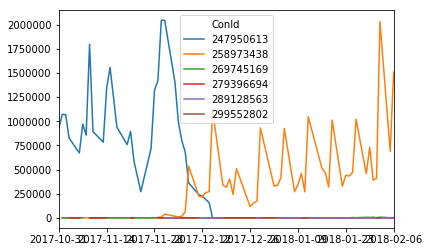

In [6]:
daily_volumes.plot()

Assuming your data spans one or more rollover dates, you should be able to see as the trading volume shifts from one contract to the next.

## Rollover Rules ##

Each futures expiry is stored in your securities master database and price history databases as a separate contract. You can define rollover rules for the futures contracts you trade, and QuantRocket will automatically calculate the rollover date for each expiry and store it in the securities master database. Your rollover rules are used to determine the front month contract when stitching together continuous futures contracts and when automating position rollover. (Note that your rollover rules are not used by Zipline as it handles futures rollover internally.)

The demo repository ships with a [rollover rules configuration file](/jupyter/edit/quantrocket.master.rollover.yml) which you can edit as desired. When you query futures contracts from the securities master service, you will see your rollover rules reflected in the `RolloverDate` field.   

In [7]:
from quantrocket.master import download_master_file

In [8]:
f = io.StringIO()
download_master_file(
    f, universes=["demo-fut"], 
    fields=["Symbol", "LocalSymbol", "PrimaryExchange", "LastTradeDate", "RolloverDate"])

In [9]:
contracts = pd.read_csv(f, parse_dates=["LastTradeDate", "RolloverDate"])
contracts.head()

,ConId,Symbol,LocalSymbol,PrimaryExchange,LastTradeDate,RolloverDate
0,156974384,ES,ESU5,GLOBEX,2015-09-18,2015-09-10
1,167205842,ES,ESZ5,GLOBEX,2015-12-18,2015-12-10
2,177525433,ES,ESH6,GLOBEX,2016-03-18,2016-03-10
3,187532577,ES,ESM6,GLOBEX,2016-06-17,2016-06-09
4,197307551,ES,ESU6,GLOBEX,2016-09-16,2016-09-08


## Continuous Futures ##

When you query historical futures data, by default each futures expiry is returned separately. You can optionally use the `cont_fut` argument to instruct QuantRocket to join individual expiries into a continuous contract when you query your historical futures data. At the time of this writing, the only supported value for `cont_fut` is `"concat"`, which concatenates the contracts on the rollover dates without any price adjustments. In the future, other joining algorithms will be added. 

In [10]:
f = io.StringIO()
download_history_file("demo-fut-1min", f, fields=["Close"], cont_fut="concat")

The resulting DataFrame contains a single column, whose ConId corresponds to the ConId of the current front-month contract. 

(Note that `cont_fut` also works properly when the query includes multiple futures underlyings, or a mix of futures and other security types.)

In [11]:
prices = pd.read_csv(f, parse_dates=["Date"])
prices = prices.pivot(index="ConId", columns="Date").T
prices.head()

ConId                      258973438
      Date                          
Close 2017-10-31 13:30:00    2572.50
      2017-10-31 13:31:00    2572.25
      2017-10-31 13:32:00    2572.50
      2017-10-31 13:33:00    2572.00
      2017-10-31 13:34:00    2571.50

For now, let's simply plot the closing prices of our continuous contract.

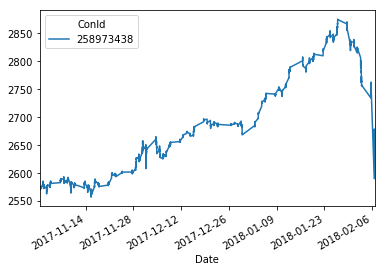

In [12]:
closes = prices.loc["Close"]
closes.plot()

## Next steps

Now that you learned about querying and analyzing your futures data in a research notebook, you can continue with the [Getting Started with Futures](https://www.quantrocket.com/tutorials/futures/) tutorials and learn how to run backtests.